In [1]:
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2
import spatialpy
import numpy
import matplotlib.pyplot as plt


In [2]:
class All(spatialpy.SubDomain):
    def inside(self, x, on_boundary):
        return True

class Walls(spatialpy.SubDomain):
    ''' Outside of the unit square'''
    def inside(self, x, on_boundary):
        if x[0] < 0.0 or x[0] > 1.0 or \
           x[1] < 0.0 or x[1] > 1.0:
            return True
        return False

In [159]:
class ChemicalGradient(spatialpy.Model):
    def __init__(self):
        spatialpy.Model.__init__(self,"ChemicalGradient")
        
        # System constants
        D = 0.1              # diffusion constant of the chemical species
        cLow = 50            # low value for boundary condition concentration
        cHigh = 100          # high value for boundary condition concentration
        
        nxF,nyF = 50,50      # number of fluid particles in x and y-direction
        nu  = 1.             # fluid viscosity
        L   = 1.             # characteristic lenght of the cavity (= width = height)
        nW  = 3              # number of wall points
        rho = 1.             # fluid density

        # Discretization
        nxTot = nxF + 2*nW # total number of particles in x-direction (including walls)
        nyTot = nyF + 2*nW # total number of particles in y-direction (including walls)
        
        # Compute domain bounds (including the boundary)
        dx,dy = L/(nxF-1),L/(nyF-1)
        xLim = ((0-(nW-1)*dx),1+(nW-1)*dx)
        yLim = ((0-(nW-1)*dy),1+(nW-1)*dy)
        
        # Compute volume and mass per particle
        vol = (xLim[1]-xLim[0])*(yLim[1]-yLim[0])*1.0 # in 2D simulations, consider z-lenght = 1
        mPP = rho*vol/(nxTot*nyTot)                   # density * total volume / total number of particles
        
        # Create mesh object
        print("xlim={0} ylim={1} nx={2} ny={3}".format(xLim, yLim, nxTot,nyTot))
        self.mesh = spatialpy.Mesh.create_2D_domain(
            xLim ,yLim , nxTot, nyTot, 
            type_id=1, mass=mPP, nu = nu, fixed=False)
        
        # Define Subdomains
        self.add_subdomain(All(), 1)
        self.add_subdomain(Walls(), 2, fixed=True)
        
        # Define a chemical Species
        self.add_species(spatialpy.Species('A', diffusion_constant=D))
        
        # Boundary conditions
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            xmax=0.0,
            species = 'A',
            deterministic=True,
            value    = cLow
        ))
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            xmin=1.0,
            species = 'A',
            deterministic=True,
            value    = cHigh
        ))
        
        # Time span
        #self.timespan(numpy.linspace(0,5,1000))
        self.timespan(numpy.linspace(0,1,2))

In [160]:
model = ChemicalGradient()

xlim=(-0.04081632653061224, 1.0408163265306123) ylim=(-0.04081632653061224, 1.0408163265306123) nx=56 ny=56
totalvolume 1.1699291961682634


In [161]:
print("model.tspan",model.tspan)
print("model.timestep_size",model.timestep_size)
print("model.num_timesteps",model.num_timesteps)
print("model.output_freq",model.output_freq)

model.tspan [0. 1.]
model.timestep_size 1e-05
model.num_timesteps 99999
model.output_freq 99999


In [162]:
model.timestep_size = 1e-1
model.num_timesteps = 10
model.output_freq = 10

In [163]:
sol = spatialpy.Solver(model, debug_level=1)
%time sol.compile()

Compiling Solver.  Build dir: /tmp/spatialpy_build_oo8s_qry
CPU times: user 57.2 s, sys: 244 ms, total: 57.5 s
Wall time: 1min 3s


In [164]:
%time result = sol.run()

Elapsed seconds: 0.54
*************** initialize_rdme ******************
Creating thread to process 392 particles
Creating thread to process 392 particles
[WORKER 0] waiting to begin step 0
Creating thread to process 392 particles
[WORKER 1] waiting to begin step 0
[WORKER 2] waiting to begin step 0
Creating thread to process 392 particles
Creating thread to process 392 particles
[WORKER 3] waiting to begin step 0
Creating thread to process 392 particles
Creating thread to process 392 particles
Creating thread to process 392 particles
[WORKER 5] waiting to begin step 0
[WORKER 6] waiting to begin step 0
[WORKER 7] waiting to begin step 0
Creating thread to update x-position index
Creating thread to create output files
[0] Starting the Sort Index threads
[0] Starting the Output threads
[OUT] start output_vtk__sync_step()
[SORT] begin sort
[OUT] done output_vtk__sync_step()
[OUT] start output_vtk__async_step()
Writing file 'output0_boundingBox.vtk'
[0] Output threads finished
Writing fil

In [168]:
import math

In [169]:
math.ceil(1.0/1e-5)

100000

In [104]:
#%time result = model.run()

In [170]:
# Plot_step access the result object and search for the specified key to plot
def plot_step(key='type',index=0,time=0):
    pts, data = result.read_step(time)
    plt.figure(figsize=(15,10) )       
    if (key == 'v'):
        d = data[key]
        d = [d[i][index] for i in range(0,len(d))]
    else:
        d = data[key]
    plt.scatter(pts[:,0],pts[:,1],c=d)
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(time))
    #plt.xticks(numpy.arange(-0.6, 0.7, 0.1)) 
    #plt.yticks(numpy.arange(-0.6, 0.7, 0.1)) 
    plt.grid(linestyle='--', linewidth=1)

    
def plot_all(key='type'):
    for i,t in enumerate(result.get_timespan()):
        plot_step(key,time=i)

In [178]:
result.get_timespan()

array([0., 1.])

read_step(0) opening '/tmp/spatialpy_result_z_y7pgxt/output0.vtk'
read_step(1) opening '/tmp/spatialpy_result_z_y7pgxt/output10.vtk'


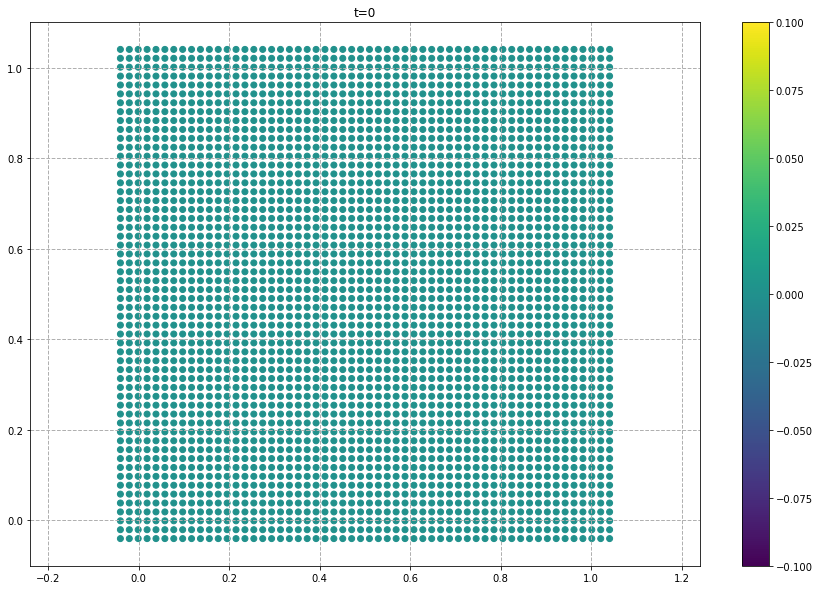

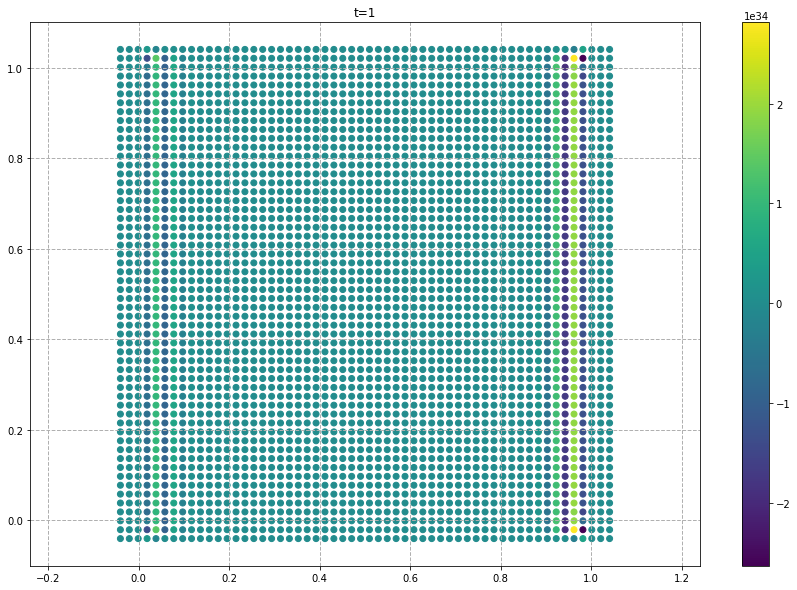

In [179]:
plot_all('C[A]')

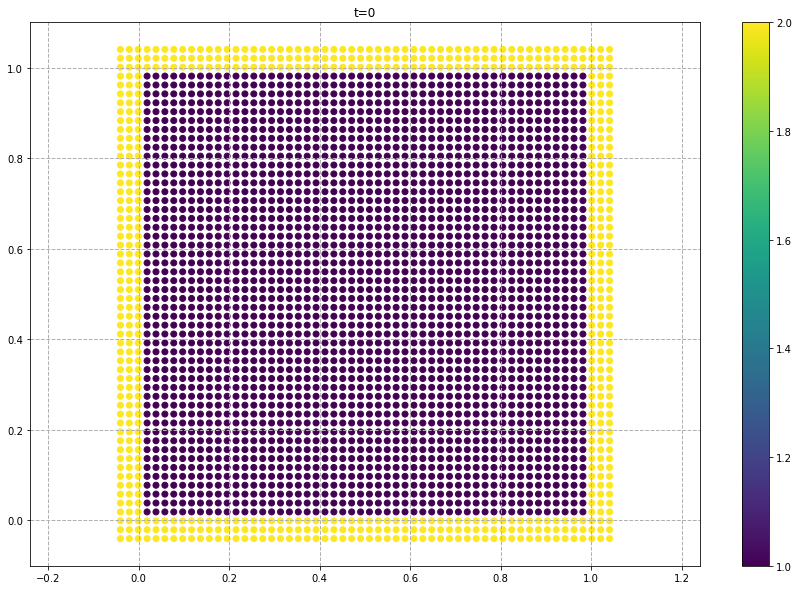

In [137]:
plot_step()

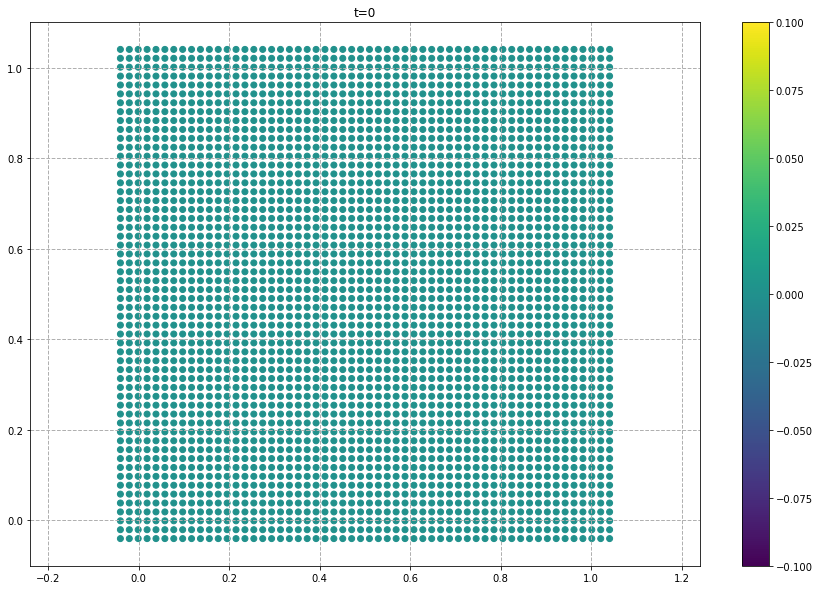

In [139]:
plot_step('C[A]',time=0)

In [134]:
result.plot_species("A", -1, deterministic=True)

In [41]:
model.tspan

array([0., 1., 2.])

In [27]:
len(result.get_timespan())

2